**Etude de faisaibilité TEXTE**
-----------------
Ce notebook a objectif d'étudier la faisabilité des éléments de description textuelle des produits.


On procéde en 3 étapes :
- **Analyse et prétraitement nécessaires des données**
- **Vectorisation numérique des données par plusieurs méthodes** : TF-IDF, Word2Vec, GloVe, FastText, USE, BERT
- **Segmentation non supervisée de ces vecteurs**
- **Mesure de la similarité entre les segments et les catégories prédéfinies**


Nous pourrons comparer ces résultats à ceux de la partie vision avant de décider quelle méthode utiliser pour la partie de classification supervisée.

# Imports

In [1]:
# Import des librairies d'usage générale
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from gc import collect
import logging
import warnings
from itertools import product
from collections import defaultdict
from tqdm import tqdm

# Import des classes pour la clustering, la réduction de dimension et les métriques
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

# Import des classes et librairies pour le traitement de texte
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_url
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer, models
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset

# Filtre tous les avertissements de type FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

# **Chargement des données nettoyées**

In [3]:
text_df = pd.read_pickle('flipkart_cleaned.pkl')
text_df.drop(columns=['image'], inplace=True)
print(text_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   product_name  1050 non-null   object  
 1   description   1050 non-null   object  
 2   class         1050 non-null   category
dtypes: category(1), object(2)
memory usage: 17.6+ KB
None


# **Analyse et prétraitement des données**

## Statistiques descriptives sur les champs textuels

**Calcul des statistiques descriptives sur le nombre de caractères des champs textuels:**

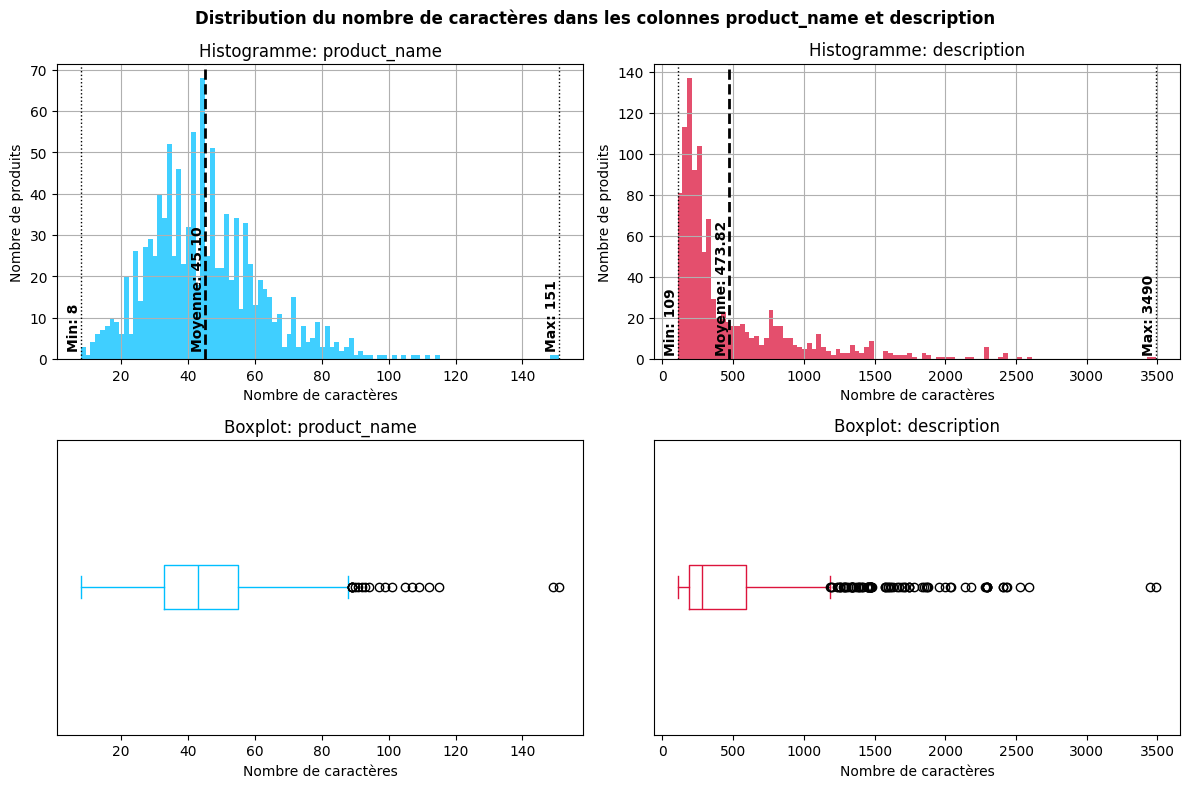

In [4]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de caractères dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = text_df[column].str.len()
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de caractères', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de caractères', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()
    


**Les éléments clés à tirer de cette visualisation**:
- `Product_name` : Distrubution gaussienne avec une moyenne et une médiane très proche et peu de valeurs extrêmes.
- `Description` : Distribution asymétrique avec une médiane bien plus basse que la moyenne et beaucoup de valeurs extrêmes. Présence de bruit dans les données peut être très importante.


**Passons à présent à l'analyse des tokens:**

In [5]:
# Charge un modèle de langue anglaise basique pour tokenizer
nlp = spacy.blank('en')

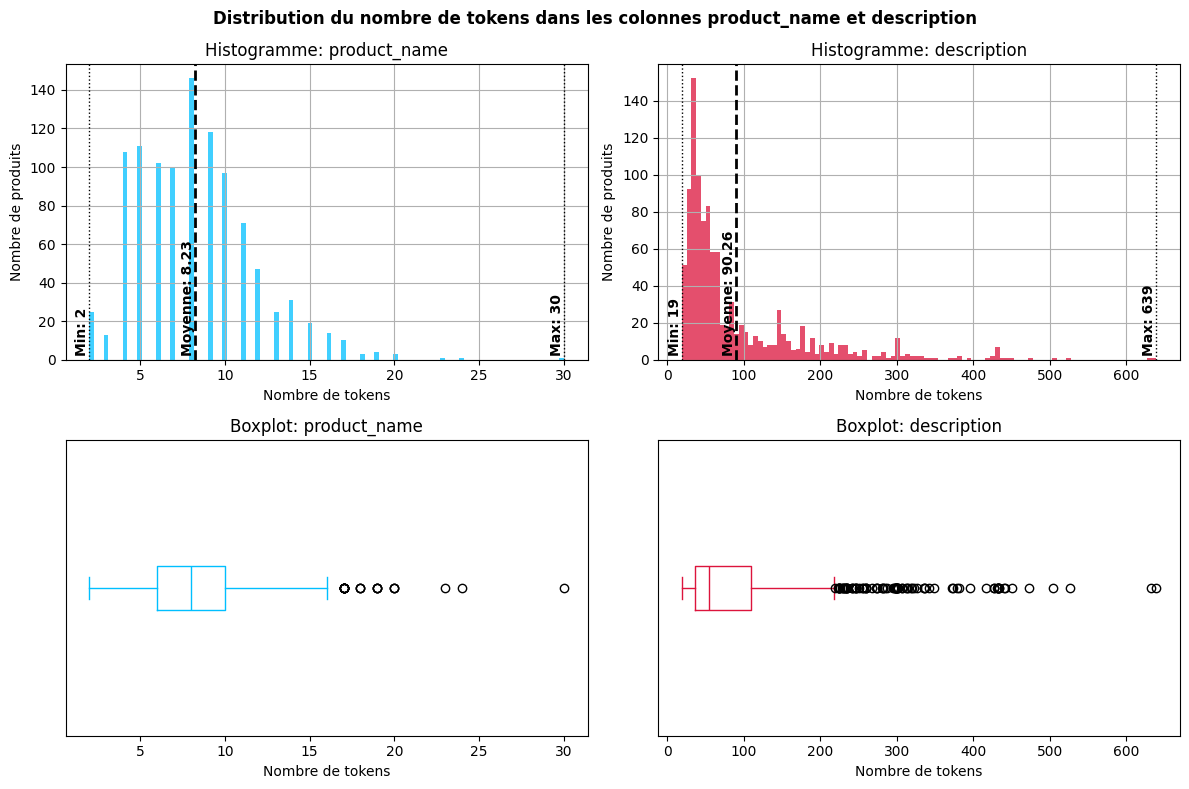

In [6]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution du nombre de tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule le nombre de caractères pour chaque produit
    series = pd.Series([len(doc) for doc in nlp.pipe(text_df[column].values)])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Nombre de tokens', ylabel='Nombre de produits', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Nombre de tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()
    

Parmi les tokens extraits, regardons à présent leur longueur et leur fréquence d'apparition:


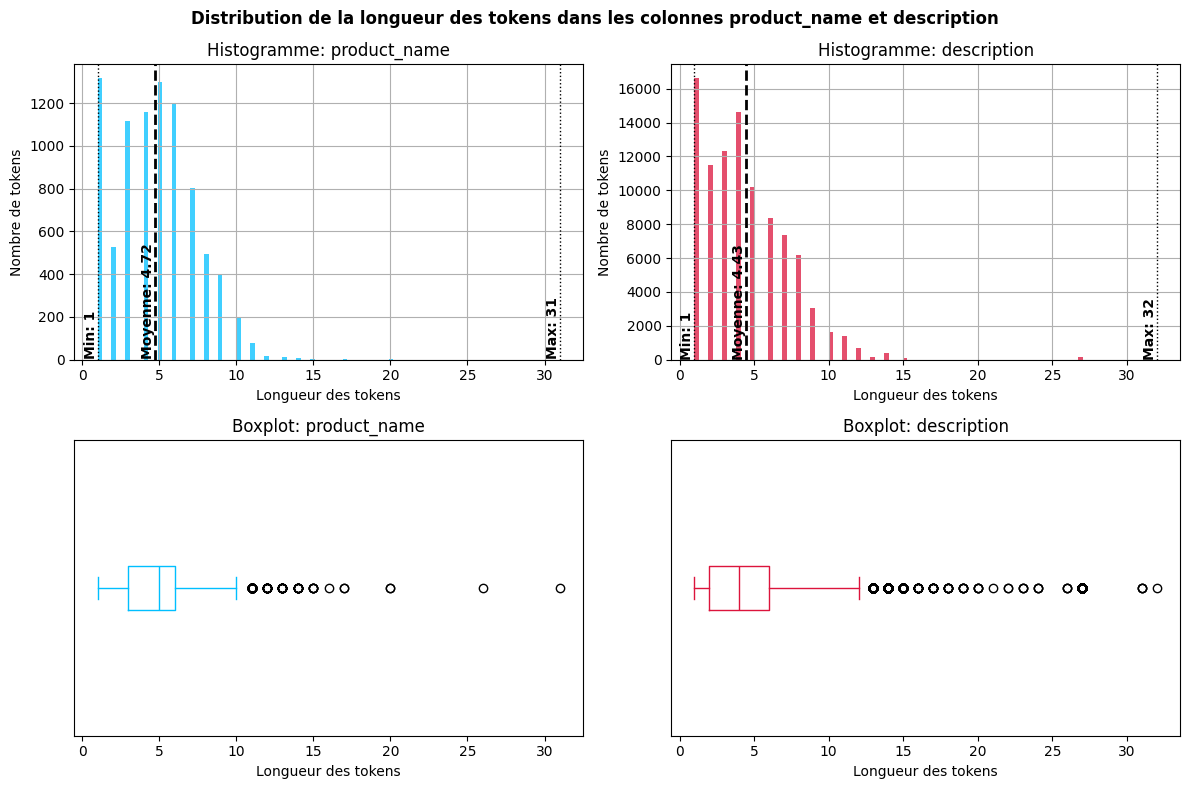

In [7]:
# Création de la figure avec 4 plots en format (2, 2)
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
fig.suptitle('Distribution de la longueur des tokens dans les colonnes product_name et description', fontweight='bold')

# Pour chaque colonne, on crée un histogramme et un boxplot
for i, (column, color) in enumerate(zip(
    ('product_name', 'description'),
    ('deepskyblue', 'crimson'),
    )):
    # On calcule la longueur de chaque token pour chaque produit
    series = pd.Series([len(token) for doc in nlp.pipe(text_df[column].values) for token in doc])
    # On calcule le min, max et la moyenne
    min, max, mean = series.min(), series.max(), series.mean()
    # On crée l'histogramme et on ajoute les lignes pour la moyenne, le min et le max
    series.hist(bins=100, color=color, alpha=0.75, ax=ax[0, i]).set(xlabel='Longueur des tokens', ylabel='Nombre de tokens', title=f'Histogramme: {column}')
    ax[0, i].axvline(mean, color='black', linestyle='dashed', linewidth=2)
    ax[0, i].axvline(min, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].axvline(max, color='black', linestyle='dotted', linewidth=1)
    ax[0, i].text(mean, 2, f'Moyenne: {mean:.2f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(min, 2, f'Min: {min}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    ax[0, i].text(max, 2, f'Max: {max}', rotation=90, verticalalignment='bottom', horizontalalignment='right', fontweight='bold')
    # On crée le boxplot
    series.plot(kind='box', vert=False, color=color, ax=ax[1, i]).set(xlabel='Longueur des tokens', title=f'Boxplot: {column}')
    ax[1, i].set_yticks([])
# On affiche la figure
plt.show()

La fréquence la plus élévée est celle des tokens de longueur 1. **Cela est probablement dû à la présence de stopwords dans les données.**<br><br>
D'un autre côté, des tokens dont la longueur est supérieure à 13 caractères sont très peu fréquents. **Cela peut être dû à des erreurs de tokenisation ou à des mots très spécifiques.**<br>
Poussons l'analyse en regardant si nous retrouvons certains patterns spécifiques dans les tokens.

## Recherche de patterns spécifiques dans les tokens (ex: email, url, etc...)

**Recherche de patterns spécifiques telles que :**
- URLs
- emails
- Numéro de téléphone
- Citations
- hashtags

In [8]:
# Define a pattern to match urls in the description column
url = r"www\.\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type URL")
print(text_df["product_name"].str.findall(url).apply(len).value_counts().index)
print(text_df["description"].str.findall(url).apply(len).value_counts().index)

Recherche de pattern de type URL
Index([0], dtype='int64', name='product_name')
Index([0], dtype='int64', name='description')


In [9]:
# Define an email pattern to match emails in the description column
email = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type Email")
print(text_df["product_name"].str.findall(email).apply(len).value_counts().index)
print(text_df["description"].str.findall(email).apply(len).value_counts().index)

Recherche de pattern de type Email
Index([0], dtype='int64', name='product_name')
Index([0, 1], dtype='int64', name='description')


In [10]:
# Define a pattern to capture the phone numbers in the description column
phone = r"\b\d{10}\b"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type no de téléphone")
print(text_df["product_name"].str.findall(phone).apply(len).value_counts().index)
print(text_df["description"].str.findall(phone).apply(len).value_counts().index)

Recherche de pattern de type no de téléphone
Index([0], dtype='int64', name='product_name')
Index([0], dtype='int64', name='description')


In [11]:
# Define a pattern to capture hashtags
hashtag = r"#\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type hashtag")
print(text_df["product_name"].str.findall(hashtag).apply(len).value_counts().index)
print(text_df["description"].str.findall(hashtag).apply(len).value_counts().index)

Recherche de pattern de type hashtag
Index([0], dtype='int64', name='product_name')
Index([0, 32], dtype='int64', name='description')


In [12]:
# Define a pattern to capture mentions
mentions = r"@\S+"

# Find and display the urls that match the pattern in the product and description columns
print("Recherche de pattern de type mentions")
print(text_df["product_name"].str.findall(mentions).apply(len).value_counts().index)
print(text_df["description"].str.findall(mentions).apply(len).value_counts().index)

Recherche de pattern de type mentions
Index([0, 1], dtype='int64', name='product_name')
Index([0, 2, 4, 1], dtype='int64', name='description')


Les pattern spéciaux ne sont pas fréquent dans notre jeu de données.<br>
Je vais **conserver les hashtags**, qui peuvent faire apparaître des références à des catégories de produit, et **supprimer les emails présents**, qui ne sont pas pertinents pour notre étude et aussi en rapport avec **la protection des données (RGPD)**.

In [13]:
# Supprime les patterns du type email et mention pour éviter de les traiter et aussi en rapport avec les normes RGPD
text_df["product_name"] = text_df["product_name"].str.replace(email, "")
text_df["description"] = text_df["description"].str.replace(email, "")


## Inspection des tokens de taille 1 et supérieur ou égal à 13

Je vais inspecter les tokens de taille suspecte pour voir s'ils sont pertinents ou non.

In [14]:
def print_custom(data, items_per_line=5):
    """
    Affiche les éléments de la liste avec un nombre fixe d'éléments par ligne.
    
    :param data: La liste de données à afficher.
    :param items_per_line: Nombre d'éléments par ligne.
    """
    for i in range(0, len(data), items_per_line):
        print(data[i:i + items_per_line])

**Inspection des TOKENS supérieurs ou égals à 13 caractères:**

In [15]:
# Affiche tous les tokens de longueur supérieure ou égal à 13 caractères
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) >= 13]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) >= 13])
        )
)
)

['LGSWATCHES760SL', 'Multifunctional', '10,Specifications', '...................', 'electromagnetic']
['Multifunction', 'Specification', 'JayEnterprise', '13cm,3kFactory', 'CAU1116.BA0858']
['too!Dishwasher', 'craftsmanship', 'alternatively', 'distinguishes', 'INTRFERENTIAL']
['SHUVAM20PCFTSETASSORTED', 'Manufacturers', 'HPL816X3,HPL806X2,HPL836', 'authentication', 'Apl_led_black']
['Characteristics', 'Antibacterial', 'circumference', '2,Specifications', 'compatibility']
['unforgettable', 'responsibility', 'concentration', '9.825000000000001', 'iPhone4S/5/5S/5C']
['manufacturing', 'ABKL_GRN_GRN_GRN', 'FLVI50REDC2X6', '240KGT_PRINTED', 'Classification']
['Customization', 'understanding', 'Multifunctions', 'BrilliantColor', 'entrepreneurs']
['ArtRMMW50000330', 'Scientifically', 'FURNISHINGLAND', 'FLMH922BLACKC3X5', '14inch),Beautifully']
['personalizing', 'Eternity001007', 'disintegrating', 'DLST2020_WHITE_TBLUE_NAVY_PURPLE', 'cotton-5%wool']
['Craftsmanship', 'breathlessness', 'certific

On relève principalement des erreurs de tokenisation avec des caractères de ponctuation ou des mots composés mal séparés.<br>
Traitons les avec deux patterns généralistes pour corriger ce type d'erreur:

In [16]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'(?<=\w)[,-_.!()"]+(?=\w)', ' ', regex=True) # Gère les caractères de type ,-_.!() qui sont au milieu d'une chaîne de caractères
    text_df[column] = text_df[column].str.replace(r'[,]+(?=\w)', ' ', regex=True) # Gère les virgules qui sont au début d'une chaîne de caractères


**Inspection des TOKENS de 1 caractère**:

In [17]:
# Affiche tous les tokens de longueur égal à 1 caractère
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) == 1]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) == 1])
        )
)
)

['l', '"', 'N', '1', '7']
['t', '+', '2', 'Q', '\xa0']
['9', 'k', '/', 'D', '4']
['i', 'U', 'n', '•', 'K']
['S', 'C', ';', 'H', 'b']
['?', 'm', 'd', 'u', 'E']
['\r', 'W', ':', 'h', '\u2028']
['–', ']', "'", '%', 'X']
['M', 'L', 'z', 'a', 'F']
['e', 's', 'c', '3', 'v']
['[', 'R', '|', '&', '0']
[')', 'w', 'P', 'y', 'B']
['@', 'A', '!', ',', 'O']
['5', '.', '�', '…', '(']
[' ', 'x', '*', 'I', '°']
['g', '8', '“', 'V', 'J']
['”', 'T', 'Z', '6', '#']
['Y', '-', 'G', 'o']


On note la présence de caractère non ASCII, beaucoup de ponctuation et de stopwords (notamment lié aux unités de mesure).<br>
Traitons uniquement le remplacement des caractères non ASCII selon leur nature:

In [18]:
# Corrige les exceptions suivantes lors de la tokenisation
for column in ('product_name', 'description'):
    text_df[column] = text_df[column].str.replace(r'\u2028', r'\n', regex=True) # Gère les caractères de type \u2028 comme un saut de ligne
    text_df[column] = text_df[column].str.replace(r'\xa0', ' ', regex=True) # Gère les caractères de type \xa0 comme un espace
    text_df[column] = text_df[column].str.replace(r'�', '', regex=True) # Gère les caractères de type � comme une chaîne vide

**Inspection des TOKENS de 2 caractères**:

In [19]:
# Affiche tous les tokens de longueur égal à 2 caractères
print_custom(list(
    set(
    [token.text for doc in nlp.pipe(text_df['product_name'].values) for token in doc if len(token.text) == 2]
    ).union(set(
        [token.text for doc in nlp.pipe(text_df['description'].values) for token in doc if len(token.text) == 2])
        )
), items_per_line=15
)

['IN', '88', 'CD', 'c.', 'ry', 'AV', 'pc', '84', 'R+', '75', 'ky', 'rk', '47', '15', '10']
['gb', '29', '..', 'kg', 'do', 'tr', 'E.', '69', '21', '59', 'f.', '99', 'cs', '+6', 'Is']
['Al', 'E-', 'YK', 'lm', '36', 'ro', 'gm', 'se', 'No', '68', '33', 'AM', 'ed', 'Or', 'Go']
['up', 'Fs', '.2', 'sq', 'wr', 'Pc', 'O+', 'OR', 'WE', '  ', '11', '30', 'hz', '5v', 'Cm']
['95', 'wo', '23', '±3', 'Rs', '-4', 'ts', 're', 'It', 'DO', 'PC', '37', '45', 'CL', 'SJ']
['lk', 'As', 'G.', 'gx', 'we', 'rt', 'i3', 'Of', 'as', 'he', 'ml', 'Sp', '18', 'h.', 'Ft']
['77', 'II', 'To', '\n\n', '91', 'PU', 'tv', 'MH', 'no', '34', 'om', 'my', 'KE', 'EZ', 'AT']
['IS', 'co', '-2', 'ee', 'Bw', 'HD', 'FS', 'OS', '58', 'ou', '64', 'us', 'et', 'MN', 'La']
['dv', 'My', '3k', '13', '3d', 'or', 'Re', 'TV', '24', 'ha', 'of', 'ur', 'so', '65', 'mm']
['3D', 'Hp', 'ld', 'TO', '98', 'ME', 'HP', 'hd', '-3', 'e.', 'MA', '17', '12', 'If', 'ow']
['nn', 'ad', '22', '28', 'on', 'B/', 'FB', 'll', 'At', '89', '06', '50', 'Hd', 'In', '32

A nouveau, on retrouve tout un tas de stopwords ainsi que des unités de mesure.<br>
Créons une liste de stopwords liés aux unités de mesure:

In [20]:
# Création d'une liste de stopwords liés aux unités de mesure anglaises ou françaises
stopwords = [
    'cm', 'mm', 'm', 'km', 'ft', 'in', 'yd',
    'mi', 'g', 'gm', 'kg', 't', 'oz',
    'lb', 'mg', 'l', 'ml', 'cl',
    'gal', 'pt', 'qt', 'fl', 'oz',
    'ac', 'l', 'ml', 'cl', 'c', 'f'
]

## Libération de la mémoire

In [21]:
# Suppression des variables intermédiaires à ne pas conserver en mémoire
del(url, email, phone, hashtag, mentions, series, min, max, mean)
collect()

45224

# **EVALUATION DE LA SEGMENTATION NON SUPERVISEE**

Pour évualuer la faisabilité du projet, **je vais utiliser différentes méthodes d'embedding de texte pour vectoriser les données textuelles et ensuite les segmenter en utilisant des algorithmes de clustering non supervisée.**


L'objectif est de voir si les segments obtenus sont cohérents avec les catégories prédéfinies.<br>
J'utiliserai **l'indice de Rand ajusté pour mesurer la similarité entre les clusters obtenus et les catégories prédéfinies.**<br>
Un score proche de 1 indique une similarité parfaite entre les clusters et les catégories alors qu'un score proche de 0 indique une similarité aléatoire.<br>


En plus du score, je vais effectueur une comparaison visuelle des clusters obtenus avec les catégories prédéfinies pour voir **si les clusters obtenus sont bien séparés et cohérents.**


Si une méthode d'embedding et de clustering donne des résultats satisfaisants, **je pourrai l'utiliser pour la classification supervisée des produits.**

In [22]:
# Définition d'une fonction pour calculer l'ARI après segmentation avec KMeans et réduction de dimension avec Tsne
def compute_ari(X, y=text_df['class'], tsne=True):
    # Détermination des clusters à partir des données avant Tsne
    cls = KMeans(n_clusters=y.nunique(), n_init=100, random_state=42)
    cls.fit(X)

    # Calcul de l'ARI
    ARI = np.round(adjusted_rand_score(y, cls.labels_), 4)

    # Réduction de dimension avec Tsne si tsne=True
    if tsne:
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            max_iter=2000,
            init="random",
            learning_rate=200,
            random_state=42,
        )
        X_tsne = tsne.fit_transform(X)
        # Retourne l'ARI, les données réduites et les clusters
        return ARI, X_tsne, cls.labels_
    else:
        # Retourne l'ARI et les clusters
        return ARI, cls.labels_

In [23]:
# Définit une fonction pour comparer les embeddings TSNE avec les catégories réelles et les clusters
def compare_cluster_and_cat(X_tsne, clusters, y=text_df['class']):
    fig = plt.figure(figsize=(13, 5), tight_layout=True)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.cat.codes, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=y.unique(),
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(clusters),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()

Nous allons conserver les meilleurs scores obtenus par chaque modèle pour les comparer à la fin.

In [24]:
# Crée une liste pour stocker les résultats
model_results = []

## Création des corpus pour chaque champ textuel

J'ai identifié dans le jeu de données deux principaux champs textuels:
- `Product_name`
- `Description`


A partir de ces champs, **je vais en créer un troisième, `full`, qui sera la concaténation des deux champs textuels.**


Je vais appliquer une fonction de preprocessing sur ces champs textuels pour les nettoyer et les transformer en tokens avant de les vectoriser avec les différentes méthodes d'embedding, notamment pour celles qui nécessitent des lemmes ou des tokens non stopwords.

In [25]:
# Charge le modèle de langue anglaise large pré-entraîné en utilisant spacy
nlp = spacy.load('en_core_web_lg', disable=['ner'])

# Affiche les composantes du pipeline
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [26]:
# Définit une fonction pour prétraiter le texte
def preprocess_text(doc, nlp=nlp, stopwords=stopwords):  
    tokens = [
        token.lemma_
        for token in nlp(doc)
        if not token.is_stop and not token.like_num and token.is_alpha and token.lemma_ not in stopwords
        ]
    return " ".join(tokens)

Je vais créer un dictionnaire qui contient les corpus prétraitées pour nos 3 champs `product_name`, `description` et `full`:

In [27]:
# Créé un dictionnaire pour stocker les données prétraitées
corpus = dict()
# Ajoute les données prétraitées pour chaque colonne
for column in ('product_name', 'description'):
    corpus[column] = text_df[column].transform(lambda x: preprocess_text(x.lower()))
# Ajoute les données prétraitées pour la colonne 'full' qui est la concaténation des colonnes 'product_name' et 'description'
corpus['full'] = corpus['product_name'] + ' ' + corpus['description']

## Count Vectorizer

La première méthode d'embedding que je vais utiliser est le **Count Vectorizer**.<br>
Je vais l'appliquer sur les 3 corpus et pousser l'analyse en regardant les mots les plus fréquents pour chaque corpus.<br>
Cela me permettra de voir si les mots les plus fréquents sont pertinents pour la segmentation non supervisée et éventuellement de détecter d'autres stopwords à retirer.

Je définis une fonction à utiliser selon le type de vectorizer (CountVectorizer, TfidfVectorizer) qui utilise une méthodologie similaire pour la création des embeddings:

In [28]:
def process_embeddings_df(vectorizer, corpus):
    """
    Transforme une matrice sparse en DataFrame.
    
    :param cv: Le vecteur CountVectorizer.
    :param corpus: Le corpus de texte.
    :return: Un DataFrame.
    """
    # Fit and transform the corpus
    embeddings = vectorizer.fit_transform(corpus)

    # Création d'un DataFrame avec les données de product_cv et les colonnes product_cv_columns
    df = pd.DataFrame(
        embeddings.toarray(),
        columns=vectorizer.get_feature_names_out()
        )
    
    # Retourne le DataFrame
    return df

Générons nos matrices d'embedding pour les 3 corpus:

In [29]:
# Crée un count vectorizer avec la suppression des accents et le reste des paramètres par défaut
cv = CountVectorizer(strip_accents="unicode")

# Crée un dictionnaire qui va contenir les embeddings pour chaque colonne
df = dict()

# Retourne le DataFrame des embeddings pour les colonnes product_name
for column in ('product_name', 'description', 'full'):
    df[column] = process_embeddings_df(cv, corpus[column])

# Affiche le nombre de features pour chaque colonne
for column in ('product_name', 'description', 'full'):
    print(f"Nombre de features pour {column}: {df[column].shape[1]}")

Nombre de features pour product_name: 1671
Nombre de features pour description: 4140
Nombre de features pour full: 4144


La dimensionnalité est logiquement plus faible pour le corpus `product_name` qui contient moins de mots que le corpus `full` et `description`.<br>
Regardons quels sont les mots qui présentent la plus haute fréquence dans chaque corpus:

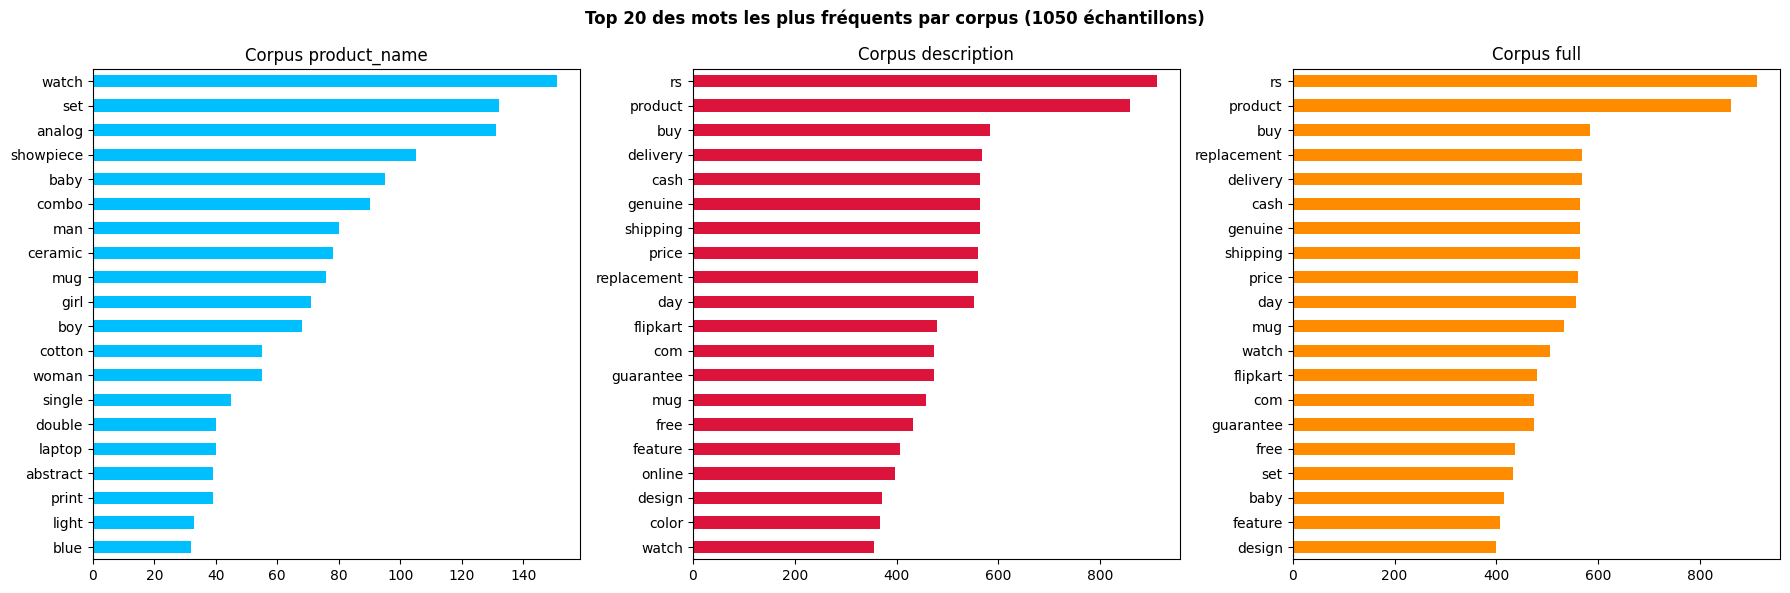

In [30]:
# Crée une figure comparant les barplot des 20 mots les plus fréquents pour chaque colonne
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
fig.suptitle(f'Top 20 des mots les plus fréquents par corpus ({len(text_df)} échantillons)', fontweight='bold')
colors = ['deepskyblue', 'crimson', 'darkorange']
# Itère sur chaque df
for i, column in enumerate(('product_name', 'description', 'full')):
    (df[column].sum(axis=0).nlargest(20)
    .sort_values(ascending=True)
    .plot(kind='barh', color=colors[i], ax=ax[i], title=f'Corpus {column}')
    )

Je constate que sur **le corpus prétraité `product_name`, les mots les plus fréquents sont des mots pertinents pour la segmentation non supervisée.**<br>
L'opération de prétraitement semble avoir bien fonctionné pour ce corpus.<br>
En revanche, **pour les corpus `description` et `full`, les mots les plus fréquents sont des stopwords.**<br>
On va calculer l'ARI pour voir l'impact de ces stopwords sur la segmentation non supervisée:

In [31]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.2646
ARI pour description : 0.0444
ARI pour full : 0.1742


**Le corpus `product_name` obtient de loin le meilleur score.**<br>
Il contient beaucoup moins de bruit, permets de mieux généraliser le sens de nos vecteurs et donc de mieux segmenter les données.<br>
**Ajoutons les fameux stopwords à notre liste de stopwords**:

In [32]:
# Ajout de nouveaux mots génériques à la liste des stopwords
stopwords.extend([
    'rs', 'product', 'buy', 'delivery', 'cash',
    'guenine', 'shipping', 'price', 'replacement',
    'day', 'flipkart', 'com', 'guarantee', 'feature',
    'free', 'price',
    ])
# Convertit la liste en set pour éliminer les duplicatas et la reconvertit en liste
stopwords = list(set(stopwords))

A ce stade, nous n'avons pas essayé différénts paramètres capables d'impacter les résutlats de la vectorisation.<br>
Je définis ue grille de recherche composée de plusieurs praramètres.<br>
**Sur cette grille, je vais tester aléatoirement 1/4 des combinaisons possibles pour chaque corpus et chaque méthode d'embedding.**<br>

In [33]:
params_grid = {
    'ngram_range': [(1, 1), (1, 2), (2,2)],
    'max_df': [0.25, 0.5, 0.75, 1.0],
    'min_df': [1, 2, 3, 5],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))
print("Minimum à tester: ", len(combinations) // 4)

Nombre de combinaisons possibles: 48
Minimum à tester:  12


In [34]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 12

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', 'description', 'full'):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, ngram_range=ngram_range, max_df=max_df, min_df=min_df)
        # Crée un DataFrame avec les embeddings
        df = process_embeddings_df(cv, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, df.shape[1], ari))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [05:19<00:00, 26.62s/it]


Tous les résultats contenant l'ARI et le paramètres utilisés ont été stockés dans un dictionnaire que je convertis en dataframe **pour visualiser les paramètres les plus impactants:**

In [35]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, n_features, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, n_features, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'n_features', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
print(scores_df.nlargest(5, 'ARI'))

          column ngram_range  max_df  min_df  n_features     ARI  ngram_code
9   product_name      (1, 1)     0.5       2         612  0.2171           0
2   product_name      (1, 1)     1.0       1        1666  0.1923           0
4   product_name      (1, 1)     1.0       1        1666  0.1923           0
26          full      (1, 1)     1.0       1        4130  0.1602           0
28          full      (1, 1)     1.0       1        4130  0.1602           0


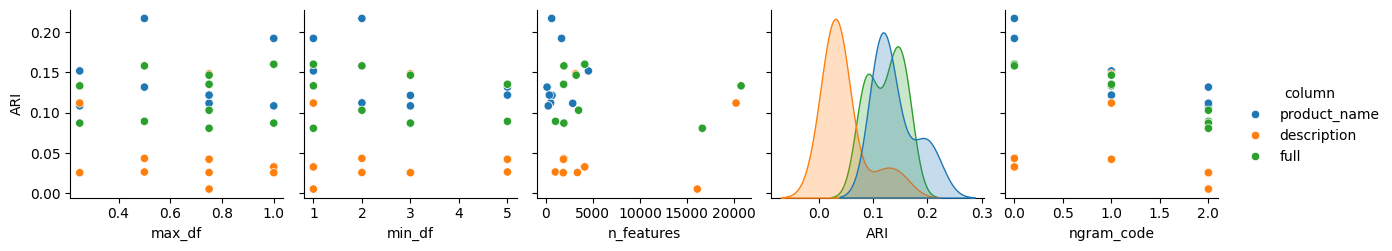

In [36]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

**Le corpus prétraité `product_name` obtient de meilleurs résultats** que les autres colonnes.<br>
Certains paramètres tels que les `ngram` ou le `min_df` (et implicitement le nombre de features) ont un impact significatif sur les résultats.<br>
**Testons cette fois sur un espace plus restreint de paramètres autour de ces valeurs optimales:**


In [37]:
params_grid = {
    'ngram_range': [(1, 1)],
    'max_df': [0.4, 0.45, 0.5, 0.55, 0.6],
    'min_df': [1, 2],
    'max_features': [500, 600, 700],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))

Nombre de combinaisons possibles: 30


In [38]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 20

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, max_features = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name',):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, ngram_range=ngram_range, max_df=max_df, min_df=min_df, max_features=max_features)
        # Crée un DataFrame avec les embeddings
        df = process_embeddings_df(cv, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, max_features, df.shape[1], ari))

100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


In [39]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, max_features, n_features, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, max_features, n_features, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'max_features', 'n_features', 'ARI']
)

# Affiche les 5 premières lignes du dataframe
print(scores_df.nlargest(5, 'ARI'))

         column ngram_range  max_df  min_df  max_features  n_features     ARI
2  product_name      (1, 1)    0.40       2           600         600  0.2722
7  product_name      (1, 1)    0.45       2           600         600  0.2722
9  product_name      (1, 1)    0.50       2           600         600  0.2722
0  product_name      (1, 1)    0.60       2           500         500  0.2695
3  product_name      (1, 1)    0.40       2           500         500  0.2695


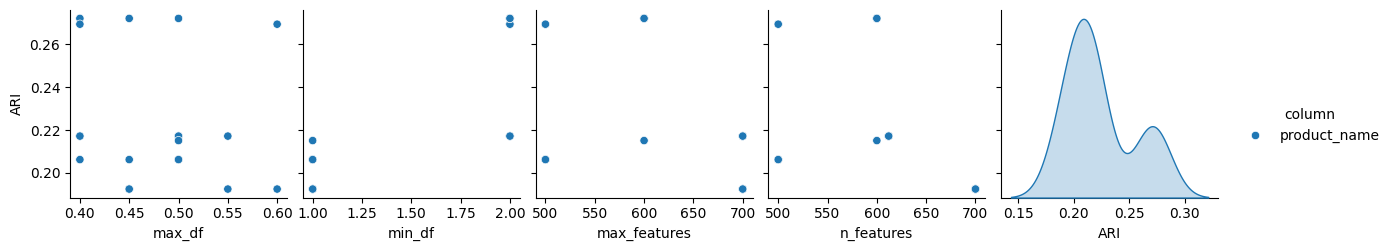

In [40]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

On a réussi à améliorer légèrement notre ARI avec une certaine combinaison de paramètres.<br>
Regardons à présent une visualisation avec des embeddings TSNE de nos vecteurs pour comparer les clusters obtenus avec les catégories prédéfinies:

ARI score: 0.2722 - Colone: product_name - Params: {'ngram_range': (1, 1), 'max_df': 0.4, 'min_df': 2, 'max_features': 600}


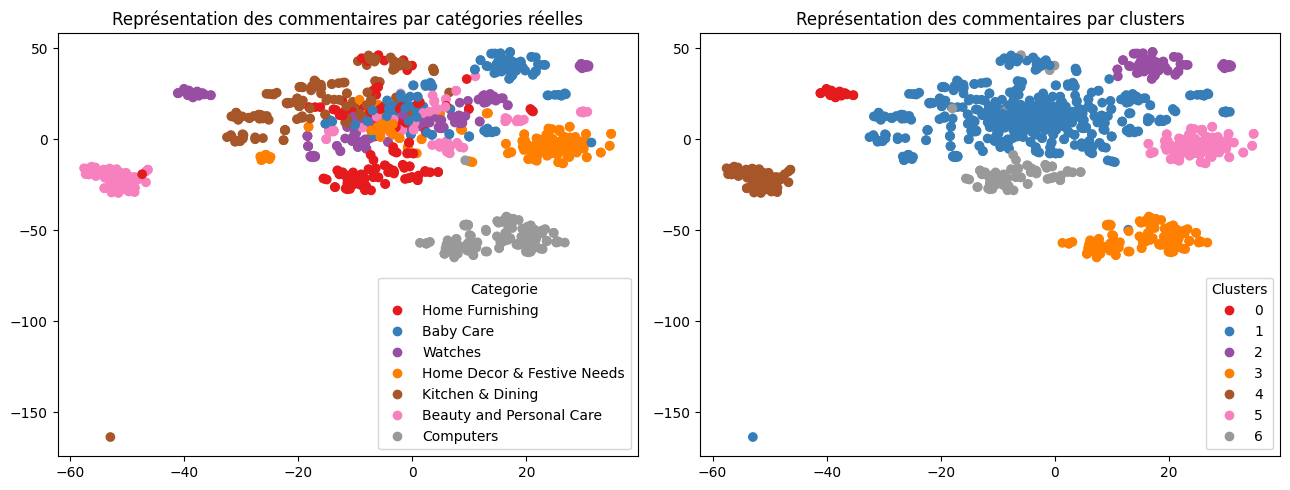

In [41]:
# Crée un CountVectorizer avec les paramètres sélectionnés
params = {"ngram_range" :(1, 1), "max_df": 0.4, "min_df": 2, "max_features": 600}
cv = CountVectorizer(strip_accents="unicode", stop_words=stopwords, **params)

# Crée un DataFrame avec les embeddings
best_feature = 'product_name'
df = process_embeddings_df(cv, corpus[best_feature])
ari, X_tsne, labels = compute_ari(df, tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Params: {params}")
compare_cluster_and_cat(X_tsne, labels)

Hormis `computers` qui arrive à bien se séparer des autres catégories ainsi que d'autres dans une moindre mesure, on constate que cette méthode n'est pas assez efficace.<br>
Elle nous aura tout de même aidée **à détecter des stopwords supplémentaires que nous utiliserons pour le TF-IDF.**

In [42]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("CV_lemma", best_feature, len(cv.get_feature_names_out()), ari))

## Tfidf Vectorizer

A la différence du CountVectorizer, le TfidfVectorizer ne compte pas simplement la fréquence brut d'apparition des mots.<br>
Il pondère cette fréquence en fonction de l'importance du mot dans le corpus et de sa fréquence d'apparition dans chacun des documents.<br>
Cela permet de donner plus d'importance aux mots rares et moins fréquents dans le corpus.<br>
**Il devrait améliorer les résultats de l'ARI et donner moins d'importance aux mots communs à toutes les catégories.**


**Nous allons reproduire exactement la même approche que pour le CountVectorizer en utilisant le TfidfVectorizer.**<br>
Dans un premier temps, calculons l'ARI sans retirer les stopwords supplémentaires pour voir si le TfidfVectorizer est plus performant que le CountVectorizer:

In [43]:
# Crée un count vectorizer avec la suppression des accents et le reste des paramètres par défaut
tfidf = TfidfVectorizer(strip_accents="unicode")

# Crée un dictionnaire qui va contenir les embeddings pour chaque colonne
df = dict()

# Retourne le DataFrame des embeddings pour les colonnes product_name
for column in ('product_name', 'description', 'full'):
    df[column] = process_embeddings_df(tfidf, corpus[column])

# Affiche le nombre de features pour chaque colonne
for column in ('product_name', 'description', 'full'):
    print(f"Nombre de features pour {column}: {df[column].shape[1]}")

Nombre de features pour product_name: 1671
Nombre de features pour description: 4140
Nombre de features pour full: 4144


In [44]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.2347
ARI pour description : 0.2381
ARI pour full : 0.2435


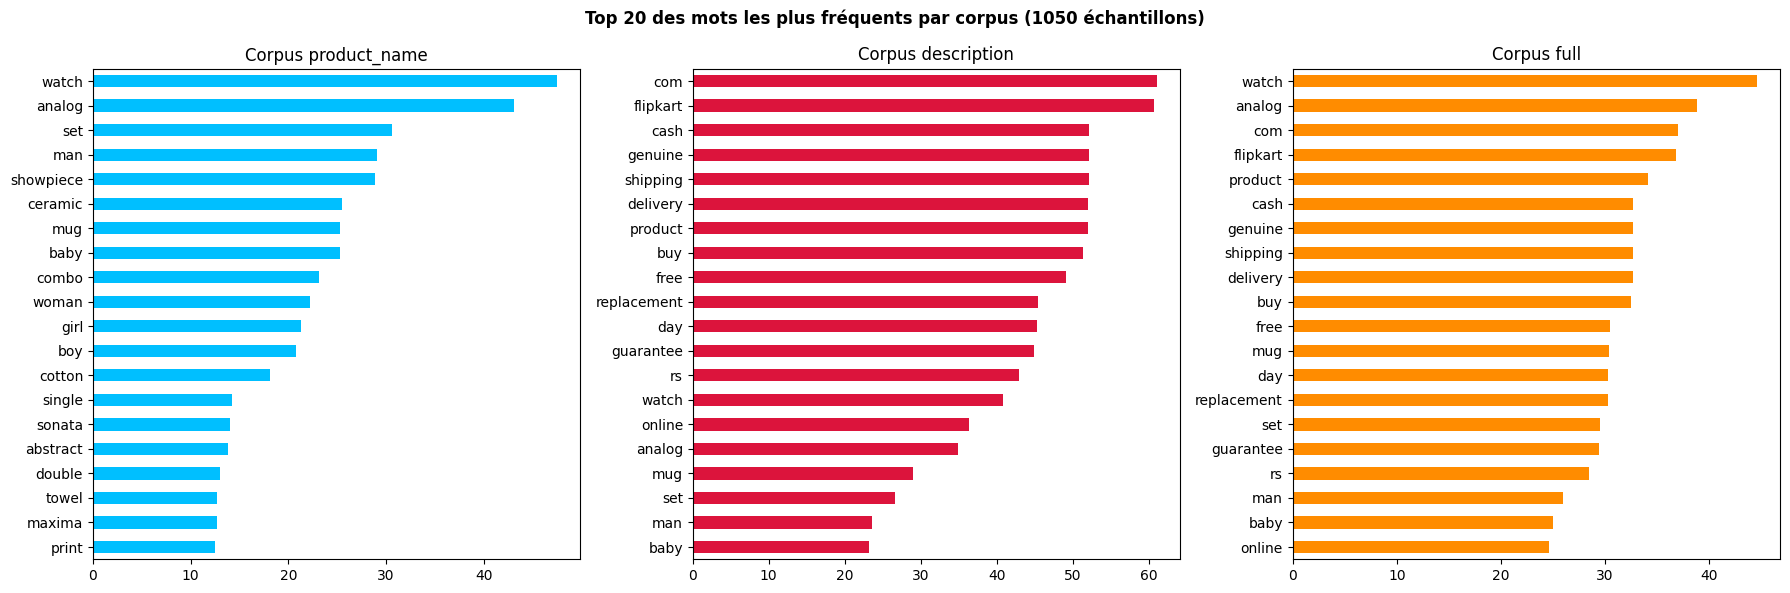

In [45]:
# Crée une figure comparant les barplot des 20 mots les plus fréquents pour chaque colonne
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)
fig.suptitle(f'Top 20 des mots les plus fréquents par corpus ({len(text_df)} échantillons)', fontweight='bold')
colors = ['deepskyblue', 'crimson', 'darkorange']
# Itère sur chaque df
for i, column in enumerate(('product_name', 'description', 'full')):
    (df[column].sum(axis=0).nlargest(20)
    .sort_values(ascending=True)
    .plot(kind='barh', color=colors[i], ax=ax[i], title=f'Corpus {column}')
    )

Les premiers résultats permettent effectivement d'obtenir de meilleurs scores sur les colonnes `description` et `full` sans avoir utiliser la liste de stopword mises à jour.<br>
**Le bruit commun à toutes les catégories a été réduit grâce à la pondération du Tf-Idf.**<br>
Toutefois, ces stopwords supplémentaires ont encore de l'impact donc nous allons les retirer par la suite.<br>
**Recherchons à présent les paramètres impactants pour le TfidfVectorizer:**

In [46]:
params_grid = {
    'ngram_range': [(1, 1), (1, 2), (2, 2)],
    'max_df': [0.25, 0.5, 0.75],
    'min_df': [2, 4, 6],
    'norm': ['l1', 'l2'],
    'sublinear_tf': [True, False],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))
print("Minimum à tester: ", len(combinations) // 4)

Nombre de combinaisons possibles: 108
Minimum à tester:  27


In [47]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 27

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, norm, sublinear_tf = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', 'description', 'full'):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        tfidf = TfidfVectorizer(
            strip_accents="unicode", stop_words=stopwords,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            norm=norm, sublinear_tf=sublinear_tf
            )
        # Crée un DataFrame avec les embeddings
        df = process_embeddings_df(tfidf, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, df.shape[1], norm, sublinear_tf, ari))

100%|██████████| 27/27 [09:17<00:00, 20.64s/it]


In [48]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, n_features, norm, sublinear_tf, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, n_features, norm, sublinear_tf, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'n_features', 'norm', 'sublinear_tf', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
with pd.option_context('display.max_columns', 10):
    display(scores_df.nlargest(5, 'ARI'))

,column,ngram_range,max_df,min_df,n_features,norm,sublinear_tf,ARI,ngram_code
22,product_name,"(1, 1)",0.75,2,612,l2,True,0.3101,0
49,description,"(1, 1)",0.75,2,1909,l2,True,0.3055,0
74,full,"(1, 1)",0.25,6,738,l2,True,0.2881,0
1,product_name,"(1, 1)",0.50,2,612,l2,False,0.2808,0
6,product_name,"(1, 1)",0.25,2,612,l2,False,0.2808,0


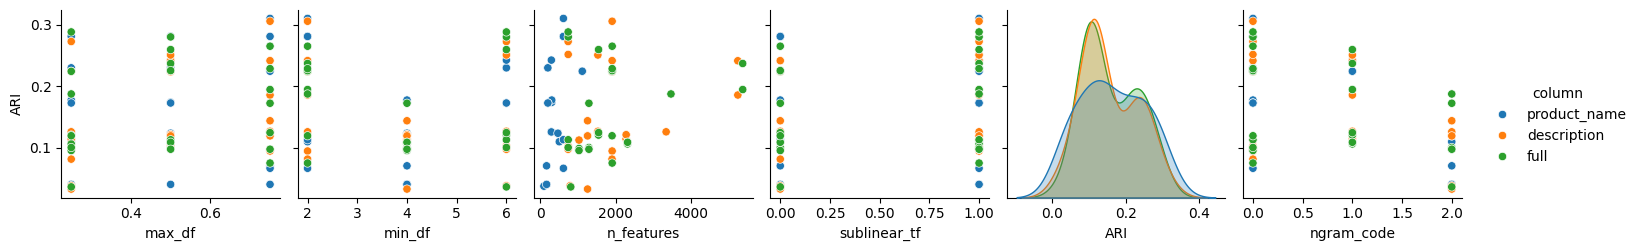

In [49]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

**Nous avons amélioré significativement l'ARI en ajustant les paramètres du TfidfVectorizer et en retirant les stopwords supplémentaires.**<br>
L'impact de certains paramètres est moins facilement discernable.<br>
Essayons d'affiner le meilleur score avec une recherche exhaustive autour des paramètres optimaux:

In [50]:
params_grid = {
    'ngram_range': [(1, 1), ],
    'max_df': [0.7, 0.75, 0.8],
    'min_df': [2, 3],
    'max_features': [350, 450, 650],
    'norm': ['l2', ],
    'sublinear_tf': [True, False],
}
# Crée une liste avec toutes les combinaisons possibles
combinations = list(product(*params_grid.values()))
# Affiche le nombre de combinaisons possibles
print("Nombre de combinaisons possibles:", len(combinations))

Nombre de combinaisons possibles: 36


In [51]:
# Fixe le seed pour la reproductibilité et le nombre d'itérations
np.random.seed(42)
n_iter = 36

# Crée un dictionnaire pour stocker les scores et les paramètres par colonne
scores_dict = defaultdict(list)

for _ in tqdm(range(n_iter)):
    # Sélectionne aléatoirement une combinaison de paramètres
    i = np.random.choice(len(combinations), size=1, replace=False)[0]
    ngram_range, max_df, min_df, max_features, norm, sublinear_tf = combinations[i]
    # Itère sur chaque colonne
    for column in ('product_name', ):
        # Crée un CountVectorizer avec les paramètres sélectionnés
        tfidf = TfidfVectorizer(
            strip_accents="unicode", stop_words=stopwords,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, norm=norm, sublinear_tf=sublinear_tf
            )
        # Crée un DataFrame avec les embeddings
        df = process_embeddings_df(tfidf, corpus[column])
        ari, _= compute_ari(df, tsne=False)
        # Ajoute un tuple avec les paramètres, le nombre de features et l'ARI
        scores_dict[column].append((ngram_range, max_df, min_df, max_features, df.shape[1], norm, sublinear_tf, ari))

100%|██████████| 36/36 [02:55<00:00,  4.87s/it]


In [52]:
# Crée un dataframe avec les scores avec les colonnes : nom_colonne, max_df, min_df, n_features, ARI
scores_df = pd.DataFrame(
    [
        (column, ngram_range, max_df, min_df, max_features, n_features, norm, sublinear_tf, ari)
        for column, scores in scores_dict.items()
        for ngram_range, max_df, min_df, max_features, n_features, norm, sublinear_tf, ari in scores
    ],
    columns=['column', 'ngram_range', 'max_df', 'min_df', 'max_features', 'n_features', 'norm', 'sublinear_tf', 'ARI']
).assign(**{'ngram_code': lambda x: x['ngram_range'].astype('category').cat.codes})

# Affiche les 5 premières lignes du dataframe
with pd.option_context('display.max_columns', 10):
    display(scores_df.nlargest(5, 'ARI'))

,column,ngram_range,max_df,min_df,max_features,n_features,norm,sublinear_tf,ARI,ngram_code
22,product_name,"(1, 1)",0.8,2,650,612,l2,True,0.3101,0
8,product_name,"(1, 1)",0.8,3,350,350,l2,True,0.2999,0
9,product_name,"(1, 1)",0.8,3,350,350,l2,True,0.2999,0
14,product_name,"(1, 1)",0.7,3,350,350,l2,True,0.2999,0
32,product_name,"(1, 1)",0.7,3,350,350,l2,True,0.2999,0


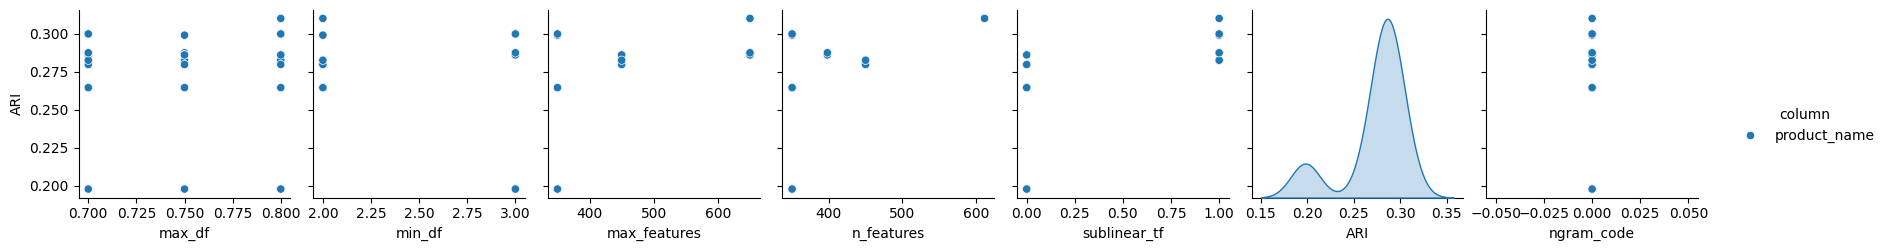

In [53]:
sns.pairplot(scores_df, hue='column', y_vars=['ARI'], diag_kind='kde', kind='scatter')
plt.show()

Nous n'obtenons pas de meilleurs résultats.<br>
Regardons la visualisation des clusters obtenus avec les embeddings TSNE:

ARI score: 0.3101 - Colone: product_name - Params: {'ngram_range': (1, 1), 'max_df': 0.8, 'min_df': 2, 'max_features': 650, 'norm': 'l2', 'sublinear_tf': True}


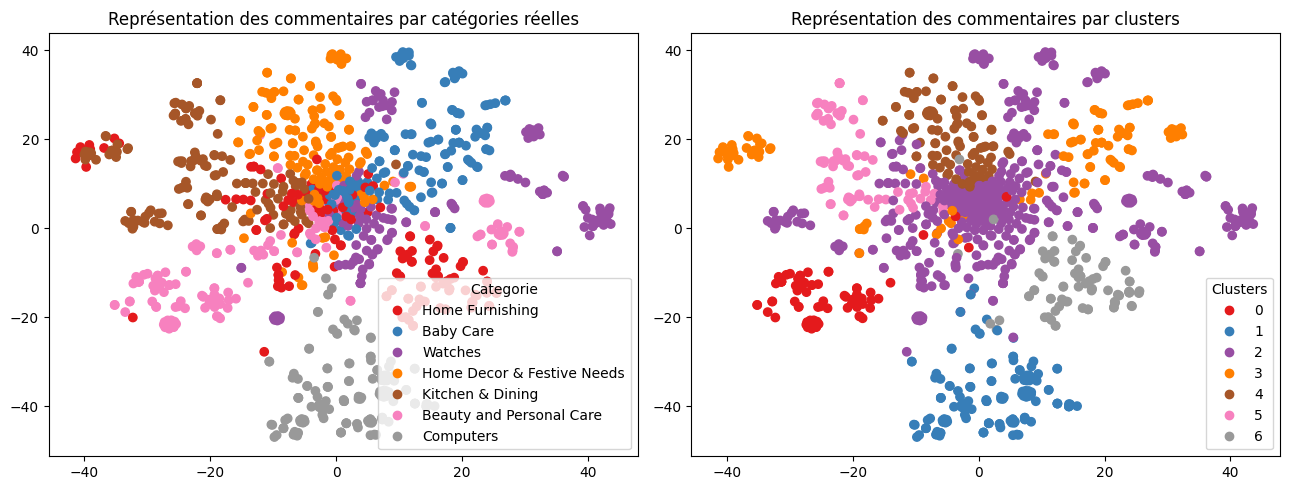

In [54]:
# Crée un TfIdfVectorizer avec les paramètres sélectionnés
params = {"ngram_range" :(1, 1), "max_df": 0.8, "min_df": 2, "max_features": 650, "norm": "l2", "sublinear_tf": True}
tfidf = TfidfVectorizer(strip_accents="unicode", stop_words=stopwords, **params)

# Crée un DataFrame avec les embeddings
best_feature = 'product_name'
df = process_embeddings_df(tfidf, corpus[best_feature])
ari, X_tsne, labels = compute_ari(df, tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Params: {params}")
compare_cluster_and_cat(X_tsne, labels)

Encore une fois, les groupes ne sont pas bien séparés.<br>
Il y a toujours un cluster central qui regroupe la majorité des catégories.<br>
Il serait possible d'essayer de réduire la dimensionnalité avec des méthodes adaptés mais nous avons d'autres méthodes d'embedding à tester qui devrait mieux convenir à ce type de données.

In [55]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("TFIDF_lemma", best_feature, len(tfidf.get_feature_names_out()), ari))

In [56]:
del(tfidf, cv, df, nlp, ngram_range, max_df, min_df, max_features, norm, sublinear_tf)
collect()

85235

## WORD2VEC

Word2Vec est un réseau de neurones à 3 couches (entrée, hidden layer - compressed feature vector, sortie) pour projeter le mot dans un nouvel espace dont les dimensions sont caractérisées par le nombre de neurones dans la couche cachée.<br>
Plus le nombre de neurones de la couche cachée augmente et plus la dimensionnalité de l'espace de projection augmente. Chaque dimension est assimilable à une caractéristique sémantique du mot qui varie en fonction du contexte dans lequel il est utilisé.<br>
Le contexte est défini par la fenêtre de contexte qui est le nombre de mots avant et après le mot à prédire.


Je vais tester deux modèles Word2Vec, entraînés sur des données wikipedia, qui diffèrent sur la taille du vecteur de projection.<br>
Ils ont tous les deux été entraînés avec la méthode Skip-Gram.<br>

### Modèle `Word2vec/wikipedia2vec_enwiki_20180420_100d`

Il a été entraîné avec les paramètres suivants : (window=5, iteration=10, negative=15, link graph)<br>
La taille de la fenêtre associé au link graph prends en compte la relation syntaxique entre les mots et cela devrait convenir pour notre corpus de description de produits avec davantage de relations syntaxiques locales.<br>
Chargons le modèle et regardons la taille du vocabulaire sur lequel il a été entraîné:


In [57]:
# Définit le repo_id et le nom du fichier du modèle 100d
repo_id = "Word2vec/wikipedia2vec_enwiki_20180420_100d"
filename = "enwiki_20180420_100d.txt"
path = './word2vec/'

# Récupère l'url pour télécharger le fichier (si besoin, en cas d'erreur de certificat SSL)
url = hf_hub_url(repo_id, filename, repo_type="model")
print(url)

# Charge le modèle Word2Vec
w2v = KeyedVectors.load_word2vec_format(path+filename, binary=False)

https://huggingface.co/Word2vec/wikipedia2vec_enwiki_20180420_100d/resolve/main/enwiki_20180420_100d.txt


In [58]:
# Compte le nombre de mots dans le vocab
vocab = list(w2v.key_to_index.keys())
print(f"Taille du vocabulaire du modèle {filename} : {len(vocab)} mots")

# Récupère la taille des vecteurs
vector_size = w2v.vector_size
print(f"Taille des vecteurs du modèle {filename} : {vector_size}")

# Crée un dictionnaire pour stocker les embeddings
w2v_map = dict()
for word in vocab:
    w2v_map[word] = w2v[word]

Taille du vocabulaire du modèle enwiki_20180420_100d.txt : 4530030 mots
Taille des vecteurs du modèle enwiki_20180420_100d.txt : 100


Nous allons tester ce modèle avec des vecteurs de taille 100 sur nos corpus sans prétraitement et avec prétraitement.<br>
A ce stade, nous ne sommes pas sûr qu'un vecteur de taille 100 soit suffisant pour bien capturer les relations sémantiques entre les mots de notre corpus non prétaité.<br>

In [59]:
embeddings = dict()
for column in ('product_name', 'description', ):
    # For each row in the text_df, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = text_df[column].str.lower().apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [60]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.3282
ARI pour description : 0.2644


Les premiers résultats sont bons mais ne sont pas bien meilleurs que ceux obtenus avec le TfidfVectorizer.<br>
Testons cette fois sur les corpus prétraités:

In [61]:
embeddings = dict()
for column in ('product_name', 'description', 'full'):
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = corpus[column].apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0  # Ajoute une condition si aucun mot n'est identifié pour renvoyer un vecteur de 0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [62]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.3414
ARI pour description : 0.2893
ARI pour full : 0.3196


Les scores sont effectivement meilleurs.<br>
Regardons la visualisation des clusters obtenus avec les embeddings TSNE:

ARI score: 0.3414 - Colone: product_name - Modèle : enwiki_20180420_100d.txt


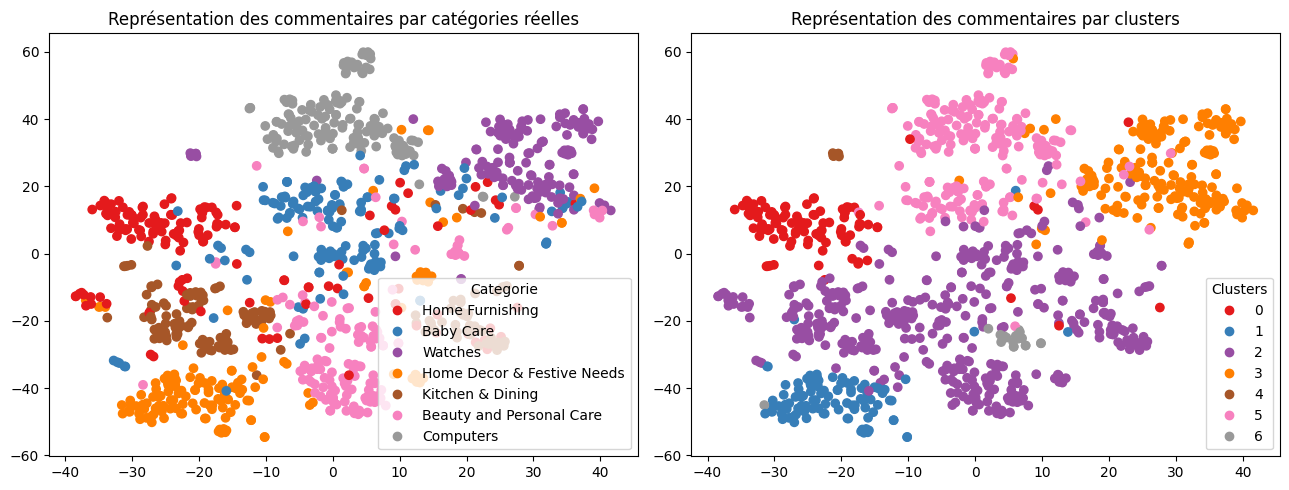

In [63]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

Les catégories sont mieux séparées que précédemment.<br>
**Toutefois, les catégories restent hétérrogènes et il y a encore des clusters qui regroupent plusieurs catégories.**<br>
Testons le modèle Word2Vec avec des vecteurs de taille 300 pour voir si cela améliore les résultats.

In [64]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("word2vec_lemma", best_feature, vector_size, ari))

### Modèle `Word2vec/wikipedia2vec_enwiki_20180420_300d`

Ce modèle a les mêmes paramètres que le modèle précédent mais avec une dimension de 300, ajoutant davantage de dimensions, et de ce fait, davantage de caractéristiques sémantiques pour chaque mot.<br>
Il est aussi beaucoup plus lourd (10 Go) et nécessite plus de temps pour être chargé.<br>


On effectue exactement la même approche que pour le modèle précédent:

In [65]:
# Définit le repo_id et le nom du fichier du modèle 100d
repo_id = "Word2vec/wikipedia2vec_enwiki_20180420_300d"
filename = "enwiki_20180420_300d.txt"
path = './word2vec/'

# Récupère l'url pour télécharger le fichier (si besoin, en cas d'erreur de certificat SSL)
url = hf_hub_url(repo_id, filename, repo_type="model")
print(url)

# Charge le modèle Word2Vec
w2v = KeyedVectors.load_word2vec_format(path+filename, binary=False)

https://huggingface.co/Word2vec/wikipedia2vec_enwiki_20180420_300d/resolve/main/enwiki_20180420_300d.txt


In [66]:
# Compte le nombre de mots dans le vocab
vocab = list(w2v.key_to_index.keys())
print(f"Taille du vocabulaire du modèle {filename} : {len(vocab)} mots")

# Récupère la taille des vecteurs
vector_size = w2v.vector_size
print(f"Taille des vecteurs du modèle {filename} : {vector_size}")

# Crée un dictionnaire pour stocker les embeddings
w2v_map = dict()
for word in vocab:
    w2v_map[word] = w2v[word]

Taille du vocabulaire du modèle enwiki_20180420_300d.txt : 4530030 mots
Taille des vecteurs du modèle enwiki_20180420_300d.txt : 300


On commence sur le corppus prétraité:

In [67]:
embeddings = dict()
for column in ('product_name', 'description', 'full'):
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = corpus[column].apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0  # Ajoute une condition si aucun mot n'est identifié pour renvoyer un vecteur de 0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [68]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.3308
ARI pour description : 0.2959
ARI pour full : 0.321


Les résultats ne sont pas significativement meilleurs que ceux obtenus avec le modèle de taille 100.<br>
Regardons ces performances sur les corpus non prétraités:

In [69]:
embeddings = dict()
for column in ('product_name', 'description', ):
    # For each row in the text_df, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = text_df[column].str.lower().apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [70]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.5219
ARI pour description : 0.291


On a d'excellents résultats sur le corpus `product_name` ! <br>
La catégorie description nécessiterait de tenir davantage compte du contexte pour obtenir de meilleurs résultats.<br>
Un modèle d'embedding plus sophistiqué avec la gestion de l'attention pourrait être nécessaire pour obtenir de meilleurs résultats sur ce type de données.<br>

ARI score: 0.5219 - Colone: product_name - Modèle : enwiki_20180420_300d.txt


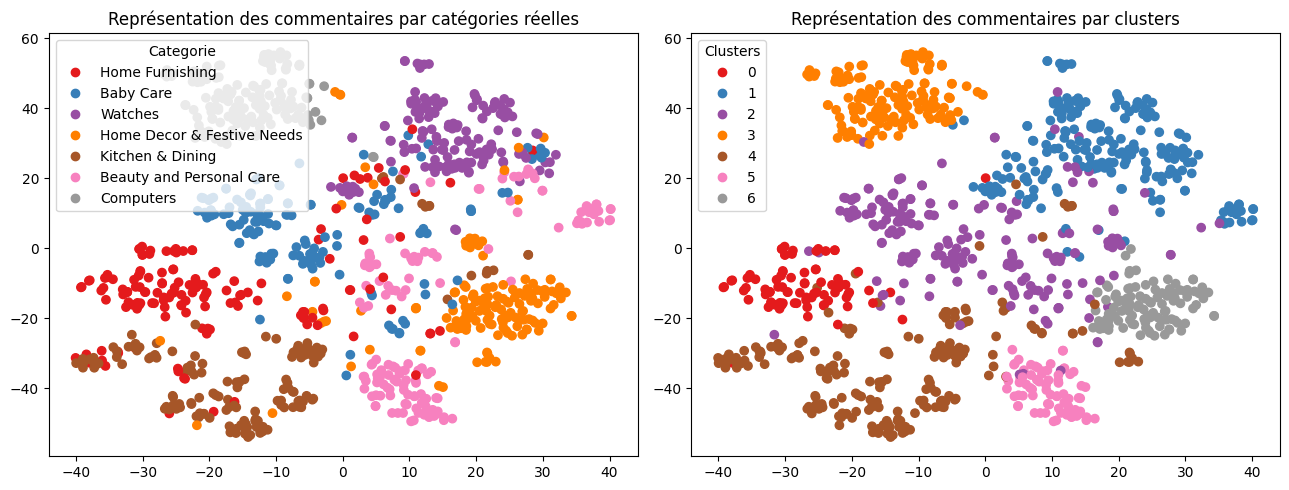

In [71]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

La séparation des clusters est bien meilleure que précédemment.<br>
La plupart des catégories sont bien séparées et on peut les identifier comparées aux clusters obtenus.<br>

In [72]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("word2vec", best_feature, vector_size, ari))

## GLOVE

A présent, je vais tester le modèle GloVe qui est un modèle de vecteurs de mots pré-entraîné sur un corpus de 6 milliards de mots de Wikipedia 2014 + Gigaword 5.<br>
Il a été entraîné avec des vecteurs de différentes tailles allant de 50 à 300.<br>
Pour la comparaison avec Word2Vec, je vais tester les vecteurs de taille 100 et 300.<br>


La particularité de GloVe est qu'il utilise une matrice de co-occurrence pour capturer les relations sémantiques entre les mots.<br>
Il est donc plus adapté pour capturer les relations sémantiques globales entre les mots que Word2Vec qui se concentre sur les relations locales.<br>


Définissons une fonction pour mapper les embeddings GloVe sur nos données:

In [73]:
# Loading the vectors from the glove text file
def load_glove_vectors(glove_file):
    with open(glove_file, "r", encoding="utf-8") as f:
        words = set()
        w2v_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            w2v_map[curr_word] = np.array(line[1:], dtype=np.float64)
    return words, w2v_map


### Modèle `stanfordnlp/glove.6B.100d`

On commence avec le modèle de taille 100.<br>
On conserve la même méthodologie que pour les modèles Word2Vec:

In [74]:
# Après avoir téléchargé le fichier zip Glove.6B (Stanford/NLP depuis huggingface), on décompresse le fichier et on utilise le modèle glove.6B.100d.txt
filename = "glove.6B.100d.txt"
path = './Glove/'

# Assigne les vecteurs Glove avec le vocabulaire sous word et le dictionnaire de mapping des vecteurs
word, w2v_map = load_glove_vectors(path+filename)

In [75]:
# Compte le nombre de mots dans le vocab
print(f"Taille du vocabulaire du modèle {filename} : {len(word)} mots")

# Récupère la taille des vecteurs
vector_size = len(w2v_map["the"])
print(f"Taille des vecteurs du modèle {filename} : {vector_size}")

Taille du vocabulaire du modèle glove.6B.100d.txt : 400000 mots
Taille des vecteurs du modèle glove.6B.100d.txt : 100


In [76]:
embeddings = dict()
for column in ('product_name', 'description', ):
    # For each row in the text_df, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = text_df[column].str.lower().apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [77]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.3374
ARI pour description : 0.2537


Les résultats sont comparables à ceux obtenus avec le modèle Word2Vec de taille 100 sur les données non prétraitées.<br>
On réalise la même opération sur les données prétraitées:

In [78]:
embeddings = dict()
for column in ('product_name', 'description', 'full'):
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = corpus[column].apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0  # Ajoute une condition si aucun mot n'est identifié pour renvoyer un vecteur de 0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [79]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.3426
ARI pour description : 0.2484
ARI pour full : 0.2973


Les résultats sont sensiblement les mêmes que ceux obtenus avec le modèle Word2Vec de taille 100 sur les données prétraitées.<br>
Regardons la visualisation des clusters obtenus avec les embeddings TSNE:

ARI score: 0.3426 - Colone: product_name - Modèle : glove.6B.100d.txt


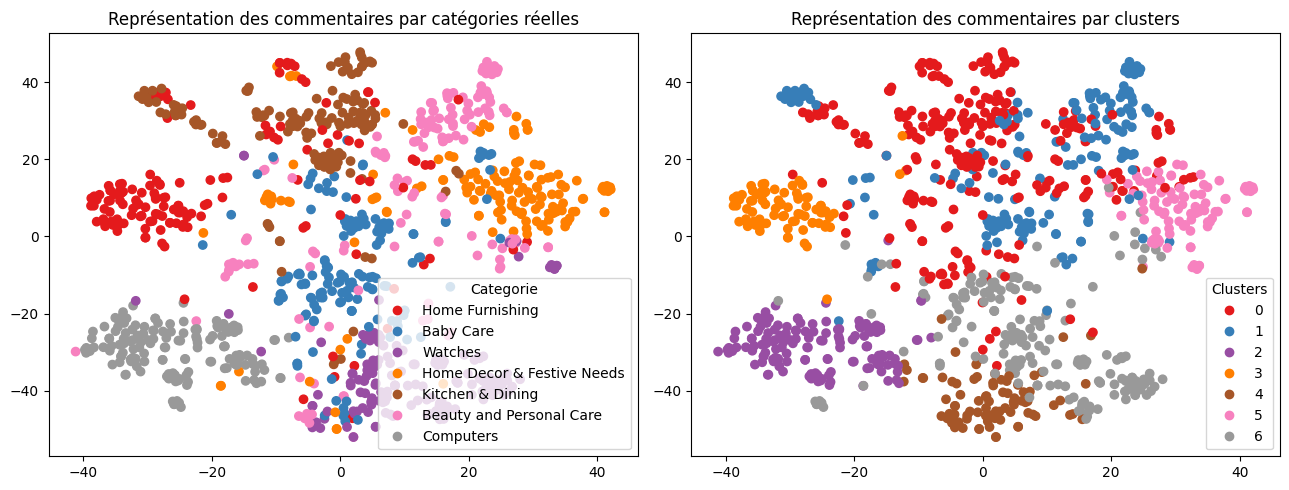

In [80]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

A l'instar de Word2Vec, les catégories se séparent mais il y a encore des zones hétérogènes.<br>
Passons au modèle de taille 300 pour voir si cela améliore les résultats.

In [81]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("glove_lemma", best_feature, vector_size, ari))

### Modèle `stanfordnlp/glove.6B.300d`

On repète la même opération que pour le modèle de taille 100:

In [82]:
# Après avoir téléchargé le fichier zip Glove.6B (Stanford/NLP depuis huggingface), on décompresse le fichier et on utilise le modèle glove.6B.300d.txt
filename = "glove.6B.300d.txt"
path = './Glove/'

# Assigne les vecteurs Glove avec le vocabulaire sous word et le dictionnaire de mapping des vecteurs
word, w2v_map = load_glove_vectors(path+filename)

In [83]:
# Compte le nombre de mots dans le vocab
print(f"Taille du vocabulaire du modèle {filename} : {len(word)} mots")

# Récupère la taille des vecteurs
vector_size = len(w2v_map["the"])
print(f"Taille des vecteurs du modèle {filename} : {vector_size}")

Taille du vocabulaire du modèle glove.6B.300d.txt : 400000 mots
Taille des vecteurs du modèle glove.6B.300d.txt : 300


In [84]:
embeddings = dict()
for column in ('product_name', 'description', 'full'):
    # For each row in the flipkart_filtered text column, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = corpus[column].apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0  # Ajoute une condition si aucun mot n'est identifié pour renvoyer un vecteur de 0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [85]:
for column in ('product_name', 'description', 'full'):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.333
ARI pour description : 0.2637
ARI pour full : 0.297


Les résultats sur le corpus prétraités ne sont pas vraiment meilleurs.<br>
Regardons les résultats sur les corpus non prétraités:

In [86]:
embeddings = dict()
for column in ('product_name', 'description', ):
    # For each row in the text_df, replace each word by its embedding and compute the mean of the embeddings
    embeddings[column] = text_df[column].str.lower().apply(
        lambda x: np.mean(
            [w2v_map[word] for word in x.split() if word in w2v_map],
            axis=0,
        )
        if len([w2v_map[word] for word in x.split() if word in w2v_map])>0
        else np.zeros(vector_size)
    )
    # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings[column] = np.stack(embeddings[column].values)

In [87]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.468
ARI pour description : 0.2699


On obtient de meilleurs résultats sur le corpus `product_name` tout comme Word2Vec mais légèrement en dessous.<br>
Cela reste tout de même très satisfaisant.<br>

ARI score: 0.468 - Colone: product_name - Modèle : glove.6B.300d.txt


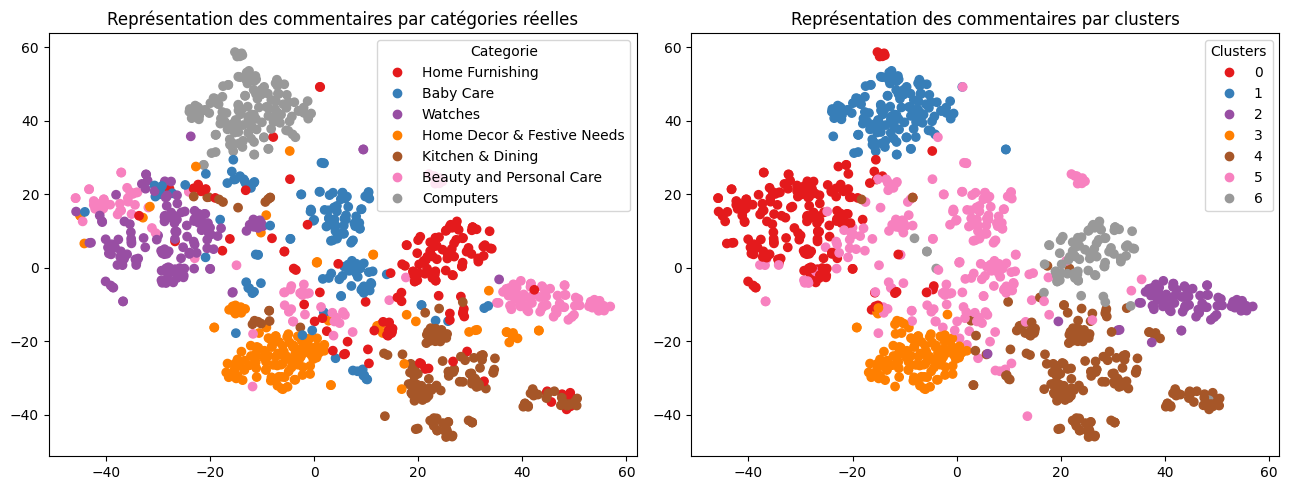

In [88]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

A nouveau, une séparation des clusters relativement nette avec des zones hétérogènes.<br>

In [89]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("glove", best_feature, vector_size, ari))

## BERT

Passons à l'utilisation de BERT qui est un modèle de langage pré-entraîné sur un très grand corpus de texte.<br>
Il s'agit d'un modèle de transformer qui utilise un mécanisme d'attention pour capturer les relations sémantiques entre les mots.<br>
Il devrait être beaucoup plus performant sur les données non prétraitées que les données prétraitées.<br>
BERT a été particulièrement innovant sur l'entraînement bidirectionnel des mots, ce qui lui permet de capturer les relations sémantiques entre les mots dans les deux sens.<br>


J'ai choisi un modèle de taille `base` pour des raisons de coût de calcul et insensible à la casse.<br>

In [90]:
# Implémente un random seed avec numpy
seed = 42
np.random.seed(seed)
# Implémente un random seed avec torch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [91]:
# Congigure le logger level à ERROR pour éviter les messages d'information
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if "transformers" in name.lower()]
# Configure tous les alertes des loggers à se déclencher uniquement en cas d'ERROR (et pas de warning)
for logger in loggers:
    logger.setLevel(logging.ERROR)

In [92]:
# Charge le modèle et le tokenizer
filename = 'bert-base-uncased'
model = BertModel.from_pretrained(filename)
tokenizer = BertTokenizer.from_pretrained(filename)

# Assigne la taille des vecteurs
vector_size = model.config.hidden_size

Notre modèle étant chargé, je crée uen fonction qui va permettre de calculer les embeddings BERT sur nos données en fonction du score d'attention pour chaque mot dans le contexte de la phrase.<br>
Pour des raisons computationnelles et aussi de performance, je vais limiter la taille maximale des phrases à 64 tokens.<br>
Ensuite, je calcule la moyenne des embeddings de chaque token par ligne dans nos données.


In [93]:
def bert_embeddings(series, model, tokenizer, batch_size=16, max_length=64):
    # Retourne les tokens encodés avec les tokens IDS, les masques d'attention et les token types IDS
    tokens_encoded = tokenizer.batch_encode_plus(
        series.tolist(), # Liste des textes à encoder
        max_length=max_length, # Longueur maximale des tokens
        truncation=True,
        padding='max_length',
        return_tensors='pt',
        add_special_tokens=True, # Ajoute les tokens spéciaux [CLS] (Classification)  et [SEP] (Séparateur)
        return_attention_mask=True, # Récupère les scores d'attention
        return_token_type_ids=True,
        verbose=False
    )
    # Crée un DataLoader pour les données
    data_loader = DataLoader(
        TensorDataset(
            tokens_encoded['input_ids'],
            tokens_encoded['attention_mask'],
            tokens_encoded['token_type_ids']
        ),
        batch_size=batch_size,
        shuffle=False  # Nous n'avons pas besoin d'effectuer un shuffle sur les données car nous n'entraînons pas le modèle
    )
    # Génère l'output à partir du dataloader
    outputs = []

    # Itère sur chaque batch
    for batch in data_loader:
        # Passe les éléments sur le modèle
        with torch.no_grad():
            output = model(
                input_ids=batch[0],
                attention_mask=batch[1],
                token_type_ids=batch[2])
        # Ajoute l'output à la liste
        outputs.append(output.last_hidden_state)
    
    # Concatene les outputs
    outputs = torch.cat(outputs, dim=0)

    # Calcule la moyenne des embeddings par ligne et les retourne sous forme de matrice numpy
    embeddings = outputs.mean(dim=1).numpy()

    # Retourne les embeddings
    return embeddings

In [94]:
embeddings_df = dict()
for column in ('product_name', 'description', ):
    # Calcule les embeddings BERT
    embeddings[column] = bert_embeddings(text_df[column].str.lower(), model, tokenizer, batch_size=16, max_length=64)
    ari, _ = compute_ari(embeddings[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.4785
ARI pour description : 0.268


ARI score: 0.4785 - Colone: product_name - Modèle : bert-base-uncased


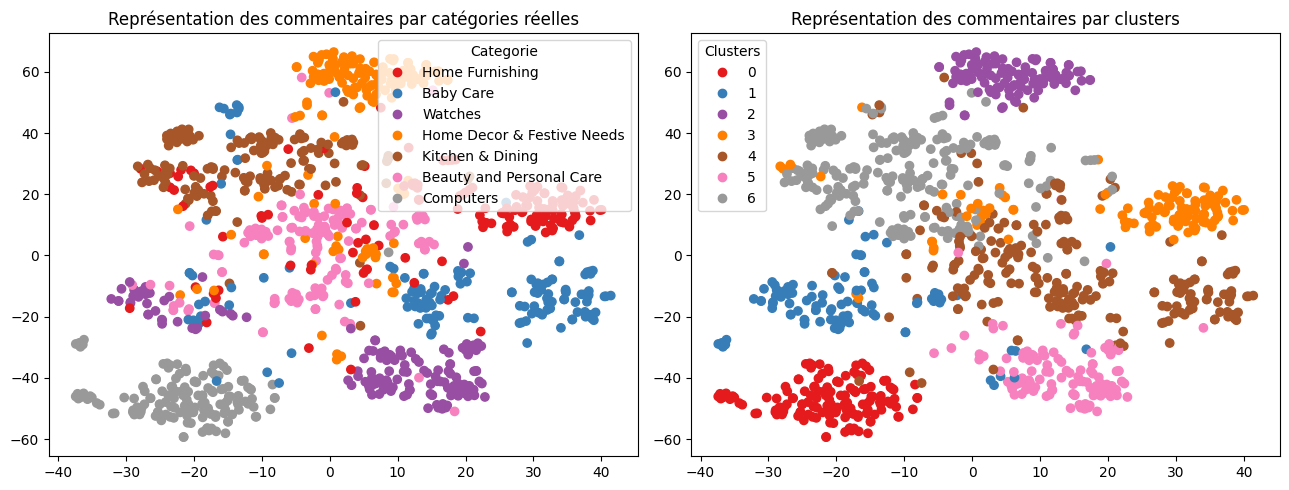

In [95]:
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

Les résultats sont très bons d'emblée sur les données non prétraitées.<br>
Il serait possible de les améliorer en ajustant les paramètres de BERT mais cela nécessiterait beaucoup de temps de calcul.<br>


Par la suite, je vais tester des modèles embeddings entraînés sur des phrases plutôt que des mots pour voir si cela améliore les résultats.

In [96]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("bert", best_feature, vector_size, ari))

## USE

Universal Sentence Encoder est un modèle de Google qui permet de transformer des phrases en vecteurs.<br>
Il est entraîné sur un très grand corpus de texte et est capable de capturer les relations sémantiques entre les phrases.<br>
Il est très performant pour la classification de texte et devrait être très performant pour la segmentation non supervisée.<br>


Nous allons utiliser le modèle `universal-sentence-encoder-4` qu'on récupère depuis le hub de tensorflow.<br>

In [97]:
# Load the Universal Sentence Encoder model
filename = 'USE'
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Assigne la taille des vecteurs
vector_size = model(["Hello"]).numpy().shape[1]

In [98]:
embeddings_df = dict()
for column in ('product_name', 'description', ):
    embeddings_df[column] = text_df[column].str.lower().apply(lambda x: np.stack(model([x]).numpy().squeeze())) # Convertit chaque valeur en matrice de dimensions 1050x100
    embeddings_df[column] = np.stack(embeddings_df[column].values)

In [99]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings_df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.5629
ARI pour description : 0.2779


Le résultat sur le corpus `product_name` est très bon.<br>
Regardons la visualisation :

ARI score: 0.5629 - Colone: product_name - Modèle : USE


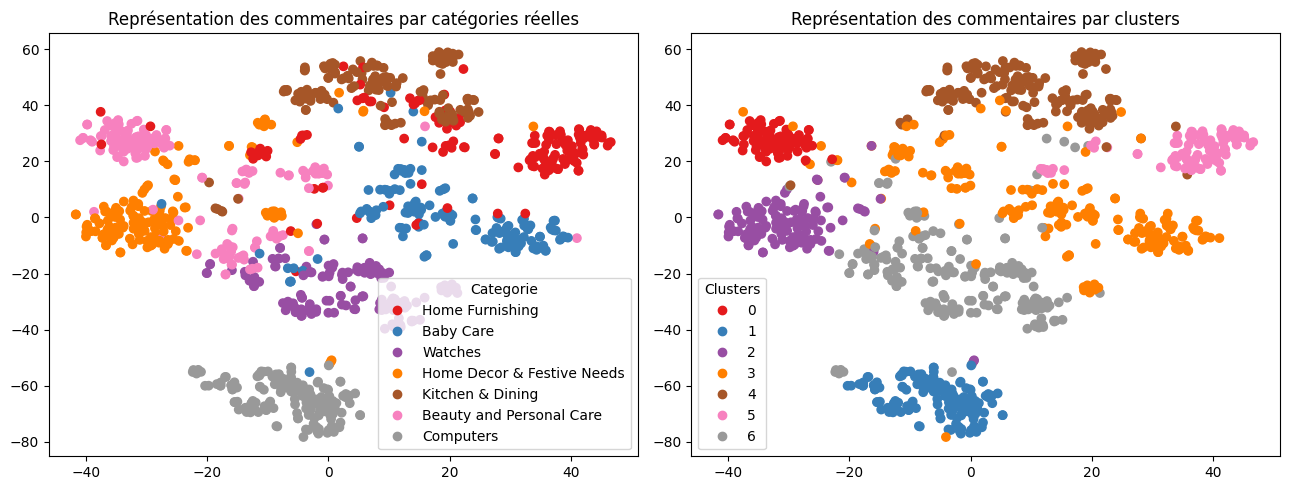

In [100]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings_df[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

Il y a moins de zones d'hétérogénéité que pour les autres modèles.<br>
Certains catégories sont très bien séparées.<br>
Comparons le résultat de ce modèle avec un modèle SOTA sur les embeddings.

In [101]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("USE", best_feature, vector_size, ari))

## SOTA `all-mpnet-base-v2`

Ce modèle a les meilleurs performances sur les sentence embeddings que l'on peut consulter sur sbert.net.<br>
Il est plus long à charger et nécessite plus de mémoire que le modèle USE.<br>
Il est basé sur le modèle MPNet qui est un modèle de transformer.<br>
Regardons les résultats:

In [102]:
# Définit le modèle à utiliser
model_path = './all-mpnet-base-v2'
filename = 'all-mpnet-base-v2'

In [103]:
# Charge le modèle Transformer
model = models.Transformer(model_path)

# Récupère la taille d'un vecteur depuis le modèle
vector_size = model.get_word_embedding_dimension()

# Charge le model de pooling
pooling_model = models.Pooling(model.get_word_embedding_dimension())

# Compile le modèle
model = SentenceTransformer(modules=[model, pooling_model])

In [104]:
embeddings_df = dict()
for column in ('product_name', 'description', ):
    embeddings_df[column] = model.encode(text_df[column].str.lower())

In [105]:
for column in ('product_name', 'description', ):
    ari, _ = compute_ari(embeddings_df[column], tsne=False)
    print(f"ARI pour {column} : {ari}")

ARI pour product_name : 0.5976
ARI pour description : 0.5065


Les résultats sont très impressionnants et sur les deux corpus non prétraités.<br>
Passons à la visualisation des clusters obtenus:

ARI score: 0.5976 - Colone: product_name - Modèle : all-mpnet-base-v2


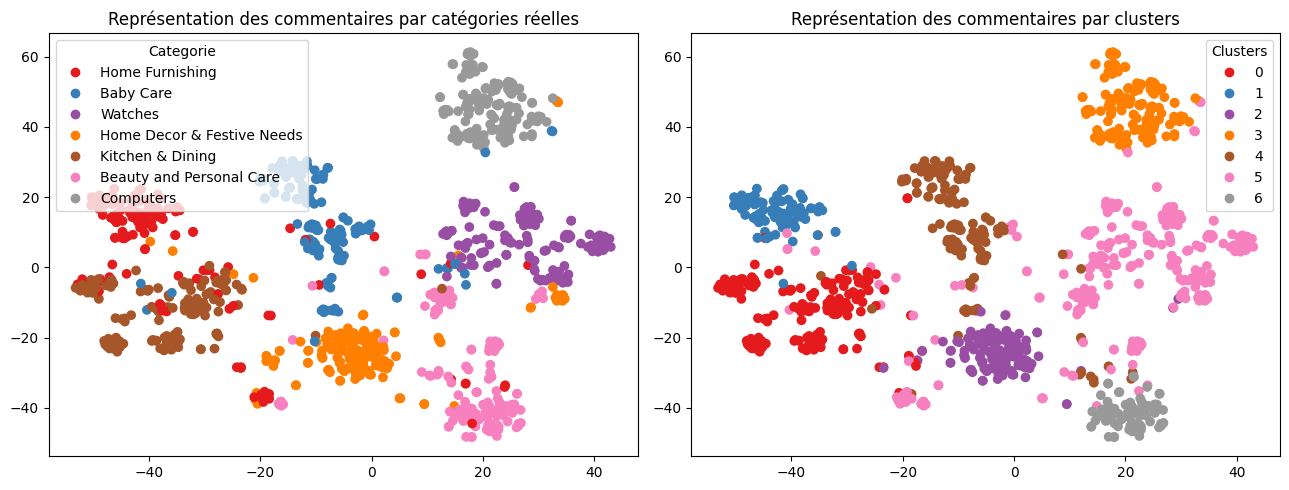

In [106]:
# Compute ari score
best_feature = 'product_name'
ari, X_tsne, labels = compute_ari(embeddings_df[best_feature], tsne=True)
print(f"ARI score: {ari} - Colone: {best_feature} - Modèle : {filename}")
compare_cluster_and_cat(X_tsne, labels)

La séparation des clusters et des catégories sont très nettes et il n'y a presque pas de zones d'hétérogénéité.<br>
Les perfomances de ce modèle sont très adaptées à nos données.


In [107]:
# Ajoute les résultats du meilleur modèle à la liste
model_results.append(("all-mpnet", best_feature, vector_size, ari))

# Comparaison des résultats

In [108]:
model_results_df = pd.DataFrame(model_results, columns=['model', 'feature', 'vector_size', 'ARI'])
model_results_df = model_results_df.sort_values('ARI', ascending=False)
model_results_df.reset_index(drop=True, inplace=True)
print(model_results_df)

            model       feature  vector_size     ARI
0       all-mpnet  product_name          768  0.5976
1             USE  product_name          512  0.5629
2        word2vec  product_name          300  0.5219
3            bert  product_name          768  0.4785
4           glove  product_name          300  0.4680
5     glove_lemma  product_name          100  0.3426
6  word2vec_lemma  product_name          100  0.3414
7     TFIDF_lemma  product_name          612  0.3101
8        CV_lemma  product_name          600  0.2722


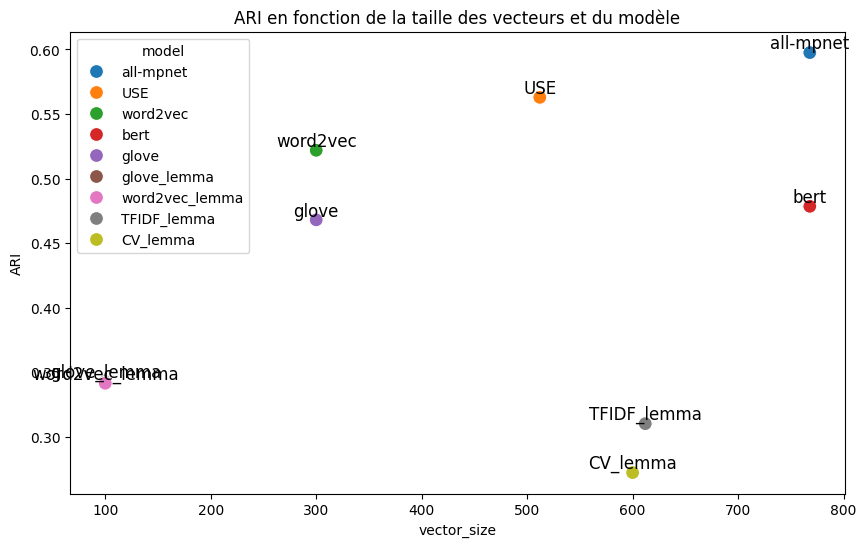

In [112]:
# Réaliser un scatter plot avec les ARI et la taille des vecteurs et en ajoutant le nom du modèle au-dessus de chaque point
plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_results_df, x='vector_size', y='ARI', hue='model', s=100)
for i, row in model_results_df.iterrows():
    plt.text(row['vector_size'], row['ARI'], row['model'], fontsize=12, ha='center', va='bottom')
plt.title("ARI en fonction de la taille des vecteurs et du modèle")
plt.show()